# Тестирование моделей

Протестируем, насколько хорошо нейронные сети, полученные нами на предыдущих шагах, определяют подсолнухи.

Посмотрим следующие характеристики:

1. TP - True Positive - количество предсказанных подсолнухов, которые совпадают с размеченными подсолнухами на 80%;
2. FP - False Positive - количество предсказанных подсолнухов, которые совпадают с размеченными подсолнухами менее, чем на 10 %;
3. FN - False Negative - количество реальных подсолнухов, которые совпадают с предсказанными подсолнухами менее, чем на 10 %.

$precision = \frac{TP}{TP \ + \ FP} \\
recall = \frac{TP}{TP \ + \ FN} \\ $

f1-score $= \frac{2 \ \cdot \ precision \ \cdot \ recall}{ precision \ + \ recall}$

В качестве метрики будем использовать f1-score, так как IoU на протяжении всего обучения была = 0.



## Импорт библиотек

In [145]:
!pip install pretrained-backbones-unet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 4.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [146]:
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm, trange
import cv2
import numpy as np
import seaborn as sns
import random

from backbones_unet.model.unet import Unet
from backbones_unet.utils.trainer import Trainer

In [147]:
import shapely
from shapely import Polygon, LinearRing

Подключаем Google Drive, чтобы иметь доступ к фотографиям для обучения модели.

In [148]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Подключаем самописные модули.

In [149]:
from dataset import *
import objects
from utils import load_image

In [173]:
def find_threshold(a, pt=10):
  arr = np.empty_like(a)
  arr[:] = a
  arr.sort()
  for i in range(2, len(arr)):
    if arr[-i-1] * pt >= arr[-i]:
      continue
    return arr[- i]


In [205]:
def filter_contours(contours, threshold):
  """
  Считает количество масок подсолнечника и удаляет выбросы.
  """
  areas = np.array([cv2.contourArea(cnt) for cnt in contours])
  res = [cnt for i, cnt in enumerate(contours) if areas[i] > threshold]
  return res

In [210]:
def crop_coords(boxes):
  """
  Находит координаты для получения наименьшего изображения,
  содержащего все рамки объектов
  x - rows
  y - columns
  """
  xu, xd, yu, yd = [float('inf'), float('-inf')] * 2

  for box in boxes:
    tmp = box.tolist()

    ud = sorted(tmp)
    lr = sorted(tmp, key=lambda pt: pt[1])

    # highest and lowest rows
    xu = xu if ud[0][0] > xu else ud[0][0]
    xd = xd if ud[-1][0] < xd else ud[-1][0]

    # leftmost and rightmost columns
    yu = yu if lr[0][1] > yu else lr[0][1]
    yd = yd if lr[-1][1] < yd else lr[-1][1]

  return xu, yu, xd, yd


def rotated_rect(contour):
  """
  Находит повернутый минимальный прямоугольник.
  """
  (cx, cy), (w, h), angle = cv2.minAreaRect(contour)
  if w == 0 or h == 0:
    return None
  c = shapely.geometry.box(-w/2.0, -h/2.0, w/2.0, h/2.0)
  rc = shapely.affinity.rotate(c, angle)
  return shapely.affinity.translate(rc, cx, cy)

def line_condition(point1, point2, way='x'):

  """
  Make line using 2 points.
  """

  y1, x1 = point1
  y2, x2 = point2

  k = (y2 - y1) / (x2 - x1)
  if way == 'x':
      return lambda x: k * (x - x1) + y1
  else:
      return lambda y: (y - y1) / k + x1

def clear_outside_box(img, box):

  # https://stackoverflow.com/questions/29739411/what-does-cv2-cv-boxpointsrect-return
  # следующий вложенный список всегда будет представлять точку,
  # которую вы получаете первой при перемещении в направлении по часовой стрелке
  p1, p2, p3, p4 = box
  lines = [line_condition(*points) for points in [(p1, p2, 'x'), (p2, p3, 'y'),
                                                  (p3, p4, 'x'), (p4, p1, 'y')]]
  line1, line2, line3, line4 = lines
  # y - row, x - col
  is_out = lambda x, y: y > line1(x) or x < line2(x) or y < line3(x) \
                            or x > line4(x)

  for r in range(img.shape[0]):
      for c in range(img.shape[1]):
          if is_out(c, r):
            img[r][c] = 0

  return img

def true_n_false_labels(real: np.ndarray | torch.Tensor,
            pred: np.ndarray | torch.Tensor,
            threshold_true: float = 0.8,
            threshold_false: float = 0.1,
            eps: float = 1e-1,
            threshold_cut: int = 3) -> tuple:

    if isinstance(real, torch.Tensor):
        real = real.numpy()

    if isinstance(pred, torch.Tensor):
        pred = pred.numpy()

    TP, FP, FN = 0, 0, 0

    contours_real, _ = cv2.findContours(real, cv2.RETR_EXTERNAL,
                                          cv2.CHAIN_APPROX_NONE)
    contours_pred, _ = cv2.findContours(pred, cv2.RETR_EXTERNAL,
                                          cv2.CHAIN_APPROX_NONE)

    areas = np.array([cv2.contourArea(cnt) for cnt in contours_real])
    thr = find_threshold(areas)
    if thr:
      contours_real = filter_contours(contours_real, thr)
    thr_p = min(np.array([cv2.contourArea(cnt) for cnt in  contours_real]))
    if thr_p:
      contours_pred = filter_contours(contours_pred, thr_p)

    for cnt_r in contours_real:
        for cnt_p in contours_pred:
            box_r, box_p = map(rotated_rect, (cnt_r, cnt_p))

            if not all((box_r, box_p)):
              continue

            if (box_r.area < eps or box_p.area < eps):
              continue

            intersection_bb = box_r.intersection(box_p)

            if not bool(intersection_bb):
              continue

            intersect_area = 0

            if isinstance(intersection_bb, shapely.geometry.collection.GeometryCollection):
              intersection_bb = intersection_bb.geoms
              for cnt_i in intersection_bb:
                intersect_area += cnt_i.area
            else:
              intersect_area = intersection_bb.area

            TP += (intersect_area / box_r.area) >= threshold_true
            FP += (intersect_area / box_r.area) < threshold_false
            FN += (intersect_area / box_p.area) < threshold_false



    return TP, FP, FN

In [153]:
def precision(TP, FP):
  if FP + TP:
    return TP / (TP + FP)
  return 0

def recall(TP, FN):
  if TP + FN:
    return TP / (TP + FN)
  return 0

def f1(TP, FP, FN):
  p = precision(TP, FP)
  r = recall(TP, FN)
  if p + r:
    return 2 * p * r / (p + r)
  return 0

In [184]:
def activate_model(path, device):
  model = Unet(
      backbone='convnext_base',
      in_channels=3,
      num_classes=1,
      )
  model.load_state_dict(torch.load(path, map_location=torch.device(device)))
  model.to(device)
  return model

def predict(model, data):
  global device
  model.eval()  # testing mode
  with torch.no_grad():
    data = data.to(device)
    pred = model(data)
    pred = (pred > 0).type(torch.uint8)
    return pred

def visual_test_model(model, img_name):
  # создадим маску и bounding box-ы для тестового изображения
  dataset_tests = PlantsDataset([(img_name, img_name)], TRAIN_IMG_DIR, TRAIN_MASK_DIR)
  pred_mask = predict(model, dataset_tests[0][0].unsqueeze(0))
  res = pred_mask.squeeze(0, 1).cpu().numpy()

  real_img  = load_image(os.path.join(TRAIN_IMG_DIR, img_name))
  real_mask = load_image(os.path.join(TRAIN_MASK_DIR, img_name))
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

  ax1.imshow(real_img)
  ax1.set_title('Source image')

  ax2.imshow(real_mask)
  ax2.set_title('Real mask')

  ax3.imshow(res)
  ax3.set_title('Predicted mask')

  plt.show()

  return res, real_img, real_mask

def poly_distribution(mask):
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_NONE)
  areas = []
  for i, contour in enumerate(contours):
    #  area = polygon_area_by_points(contour.squeeze(1))
     area = cv2.contourArea(contour)
     areas += [[i, area]]
  areas_sorted = sorted(areas, key=lambda x: x[1])
  x, y = zip(*areas_sorted)
  sns.distplot(y)

In [155]:
def plot_imgs(imgs, graph_size, titles=None):
  fig, axs = plt.subplots(*graph_size)

  for i in range(len(axs)):
    try:
      axs[i].imshow(imgs[i])
    except Exception:
      break
    if titles:
      axs[i].set_title(titles[i])
  plt.show()

## Основная программа

In [156]:
random.seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Получаем список фотографий для обучения модели. Помним, что у нас названия файлов для карт растительности и для фотографий фрагментов поля совпадают.

In [157]:
TRAIN_MASK_DIR = "/content/drive/MyDrive/plants_detection/dataset/mask"
TRAIN_IMG_DIR  = "/content/drive/MyDrive/plants_detection/dataset/img"
MODELS_DIR = "/content/drive/MyDrive/plants_detection/models"

paths_all = os.listdir(TRAIN_IMG_DIR)
paths_to_models = os.listdir(MODELS_DIR)

In [158]:
img_names = [paths_all[random.randint(0, len(paths_all))] for _ in range(200)]
paths = [os.path.join(TRAIN_MASK_DIR, name) for name in img_names]

In [159]:
stats = {model : {'precision': np.zeros(len(img_names),),
                  'recall': np.zeros(len(img_names),),
                  'f1-score': np.zeros(len(img_names),)
              } for model in [f'model_{i+1}' for i in range(len(paths_to_models))]}

test  = PlantsDataset(list(zip(img_names, img_names)),
                      TRAIN_IMG_DIR, TRAIN_MASK_DIR)

In [ ]:
len(paths_to_models)

42

Model 1
Path: model_v0 (8).2_vloss.pth


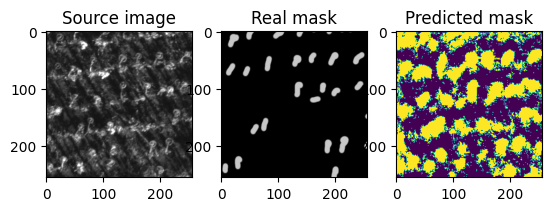

Precision: 0.89
Recall: 0.55
F1-score: 0.67
Model 2
Path: model_v0 (7).2_vloss.pth


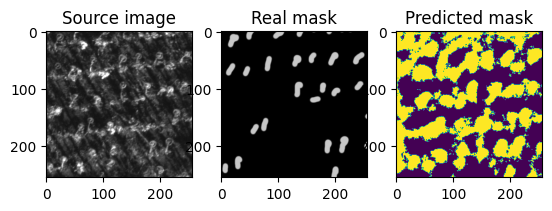

Precision: 0.98
Recall: 0.52
F1-score: 0.68
Model 3
Path: model_v0 (6).2_vloss.pth


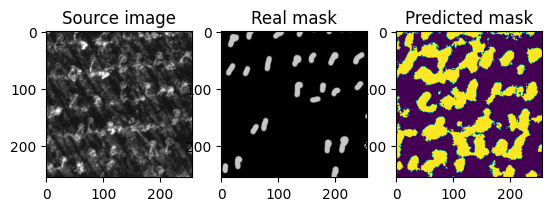

Precision: 0.97
Recall: 0.53
F1-score: 0.68
Model 4
Path: model_v0 (5).2_vloss.pth


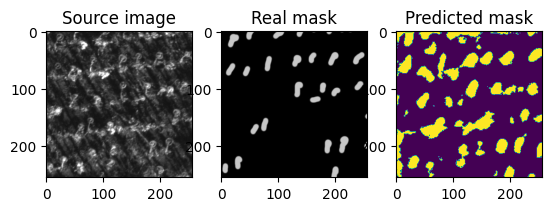

Precision: 0.9
Recall: 0.57
F1-score: 0.68
Model 5
Path: model_v0 (4).2_vloss.pth


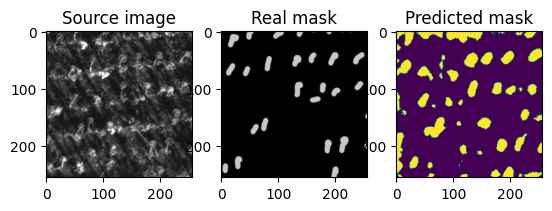

Precision: 0.91
Recall: 0.57
F1-score: 0.69
Model 6
Path: model_v0 (3).2_vloss.pth


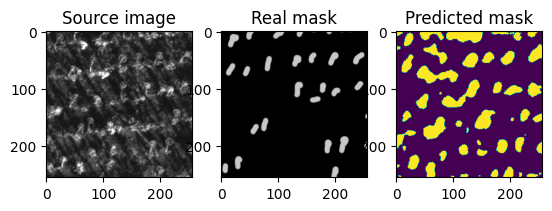

Precision: 0.93
Recall: 0.53
F1-score: 0.67
Model 7
Path: model_v0 (2).2_vloss.pth


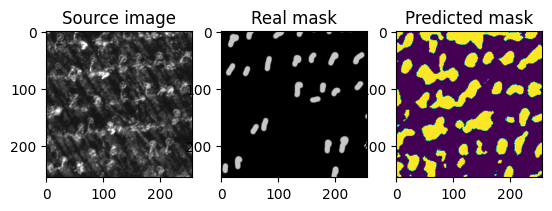

Precision: 0.98
Recall: 0.53
F1-score: 0.68
Model 8
Path: model_v0 (1).2_vloss.pth


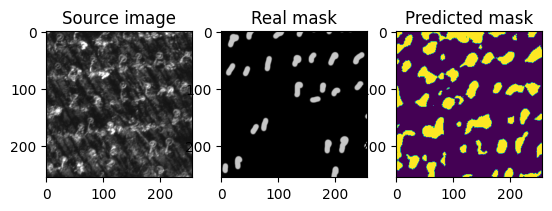

Precision: 0.93
Recall: 0.54
F1-score: 0.67
Model 9
Path: model_v0.2_vloss.pth


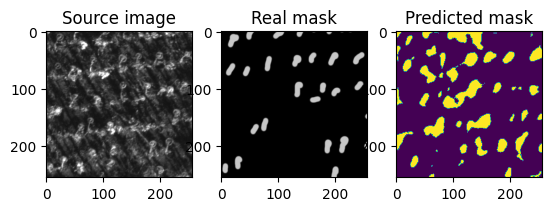

Precision: 0.92
Recall: 0.53
F1-score: 0.66
Model 10
Path: model_v0.3_0.6669_vloss0.0000_score.pth


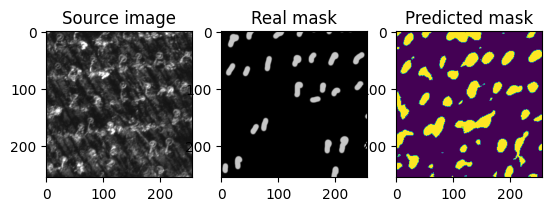

Precision: 0.82
Recall: 0.62
F1-score: 0.69
Model 11
Path: model_v0.3_0.6638_vloss0.0000_score.pth


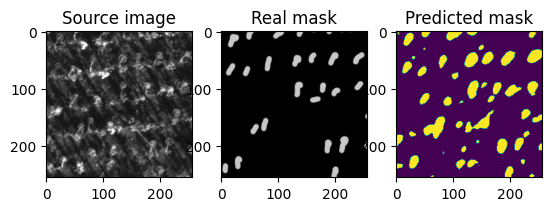

Precision: 0.71
Recall: 0.65
F1-score: 0.68
Model 12
Path: model_v0.3_0.6586_vloss0.0000_score.pth


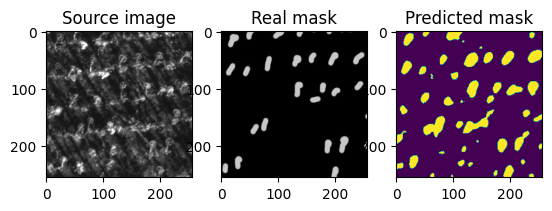

Precision: 0.7
Recall: 0.68
F1-score: 0.69
Model 13
Path: model_v0.3_0.6274_vloss0.0000_score.pth


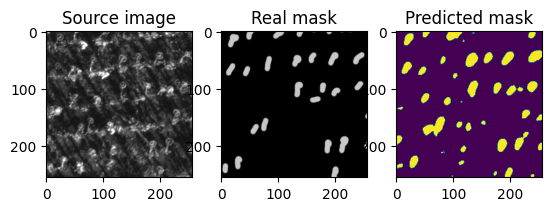

Precision: 0.44
Recall: 0.46
F1-score: 0.45
Model 14
Path: model_v0.3_0.5944_vloss0.0000_score.pth


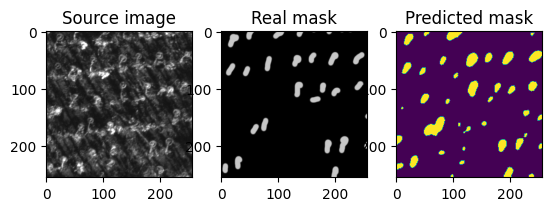

Precision: 0.32
Recall: 0.32
F1-score: 0.32
Model 15
Path: model_v0.3_0.5796_vloss0.0000_score.pth


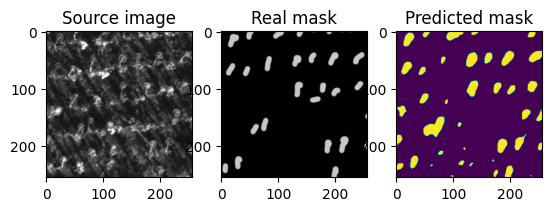

Precision: 0.42
Recall: 0.46
F1-score: 0.43
Model 16
Path: model_v0.3_0.5534_vloss0.0000_score.pth


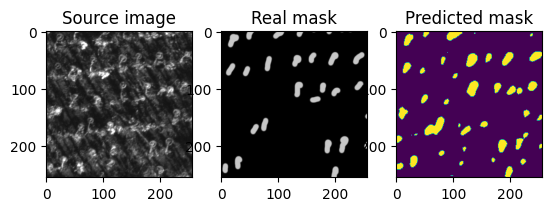

Precision: 0.3
Recall: 0.3
F1-score: 0.3
Model 17
Path: model_v0.3_0.5410_vloss0.0000_score.pth


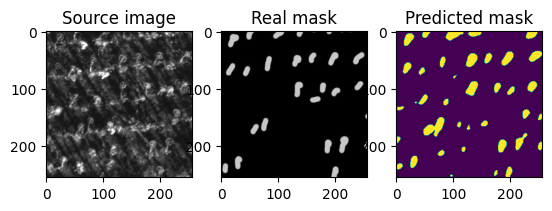

Precision: 0.26
Recall: 0.27
F1-score: 0.26
Model 18
Path: model_v0.4_0.6977_vloss0.0000_score.pth


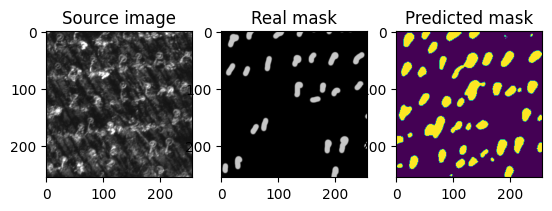

Precision: 0.48
Recall: 0.48
F1-score: 0.48
Model 19
Path: model_v0.4_0.6571_vloss0.0000_score.pth


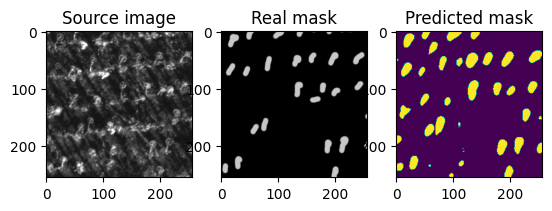

Precision: 0.34
Recall: 0.34
F1-score: 0.34
Model 20
Path: model_v0.4_0.6508_vloss0.0000_score.pth


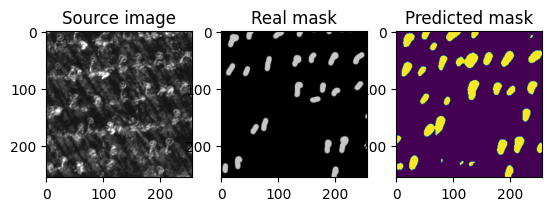

Precision: 0.26
Recall: 0.26
F1-score: 0.26
Model 21
Path: model_v0.4_0.6206_vloss0.0000_score.pth


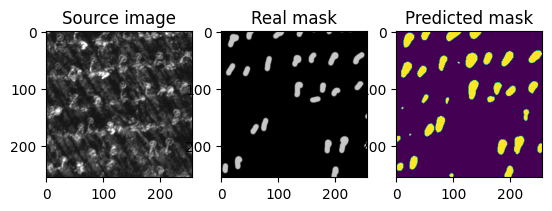

Precision: 0.27
Recall: 0.27
F1-score: 0.27
Model 22
Path: model_v0.4_0.6010_vloss0.0000_score.pth


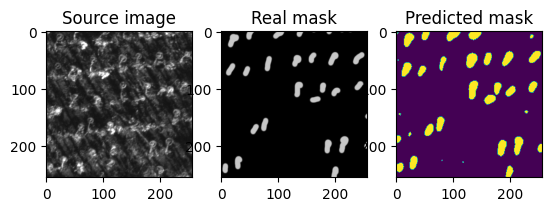

Precision: 0.25
Recall: 0.25
F1-score: 0.25
Model 23
Path: model_v0.4_0.5706_vloss0.0000_score.pth


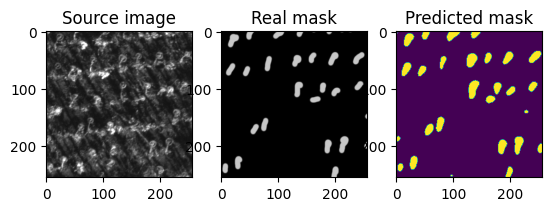

Precision: 0.2
Recall: 0.2
F1-score: 0.2
Model 24
Path: model_v0.4_0.5649_vloss0.0000_score.pth


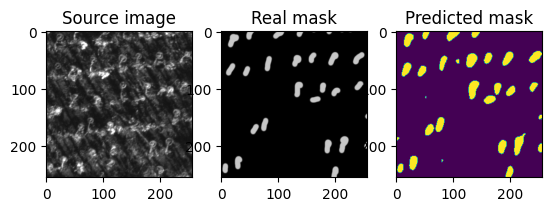

Precision: 0.25
Recall: 0.25
F1-score: 0.25
Model 25
Path: model_v0.4_0.5379_vloss0.0000_score.pth


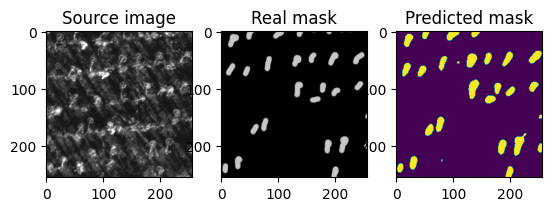

Precision: 0.19
Recall: 0.19
F1-score: 0.19
Model 26
Path: model_v0.4_0.5328_vloss0.0000_score.pth


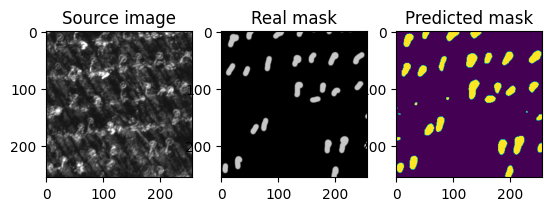

Precision: 0.25
Recall: 0.25
F1-score: 0.25
Model 27
Path: model_v0.4_0.5019_vloss0.0000_score.pth


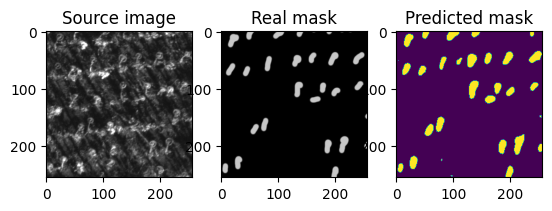

Precision: 0.18
Recall: 0.2
F1-score: 0.19
Model 28
Path: model_v0.5_0.5672_vloss0.0000_score.pth


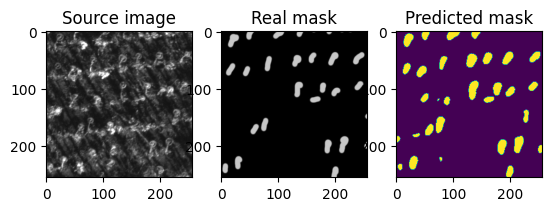

Precision: 0.3
Recall: 0.3
F1-score: 0.3
Model 29
Path: model_v0.5_0.5226_vloss0.0000_score.pth


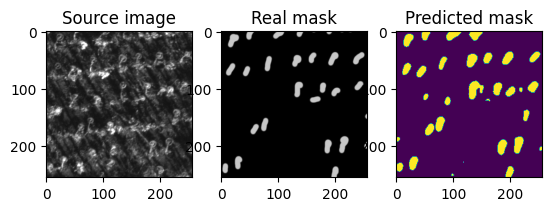

Precision: 0.25
Recall: 0.25
F1-score: 0.25
Model 30
Path: model_v0.5_0.5174_vloss0.0000_score.pth


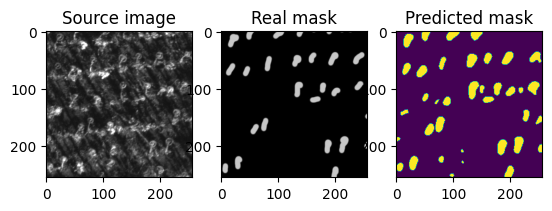

Precision: 0.2
Recall: 0.2
F1-score: 0.2
Model 31
Path: model_v0.5_0.4768_vloss0.0000_score.pth


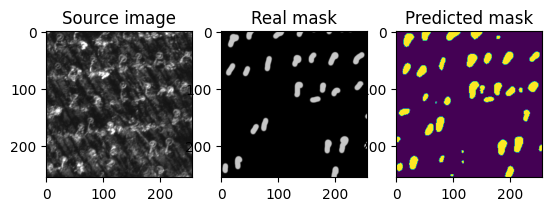

Precision: 0.35
Recall: 0.35
F1-score: 0.35
Model 32
Path: model_v0.5_0.4512_vloss0.0000_score.pth


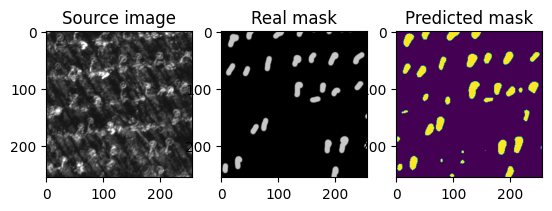

Precision: 0.25
Recall: 0.25
F1-score: 0.25
Model 33
Path: model_v0.5_0.4327_vloss0.0000_score.pth


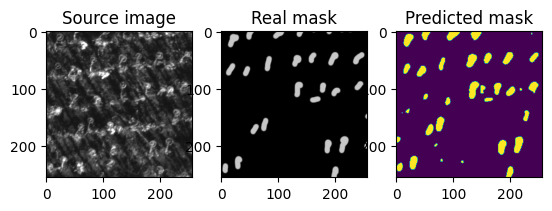

Precision: 0.22
Recall: 0.24
F1-score: 0.22
Model 34
Path: model_v0.5_0.4162_vloss0.0000_score.pth


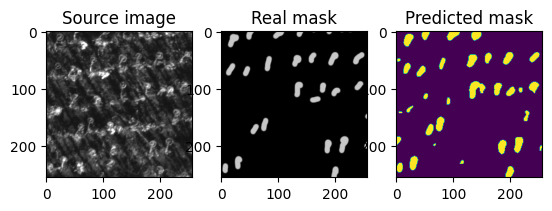

Precision: 0.2
Recall: 0.2
F1-score: 0.2
Model 35
Path: model_v0.5_0.3925_vloss0.0000_score.pth


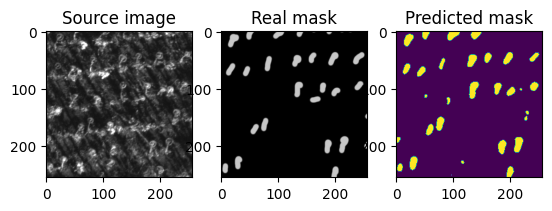

Precision: 0.13
Recall: 0.15
F1-score: 0.14
Model 36
Path: model_v0.5_0.3890_vloss0.0000_score.pth


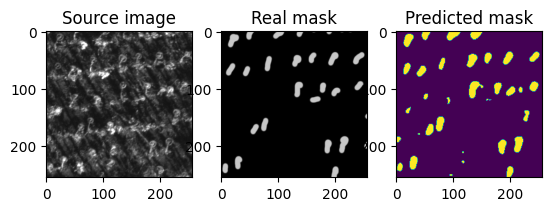

Precision: 0.19
Recall: 0.2
F1-score: 0.19
Model 37
Path: model_v0.5_0.3615_vloss0.0000_score.pth


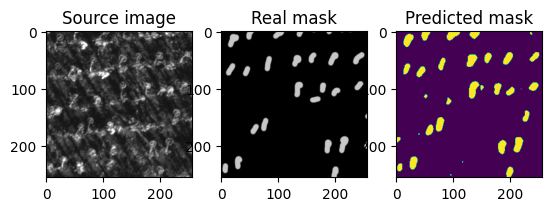

Precision: 0.18
Recall: 0.18
F1-score: 0.18
Model 38
Path: model_v0.5.pth


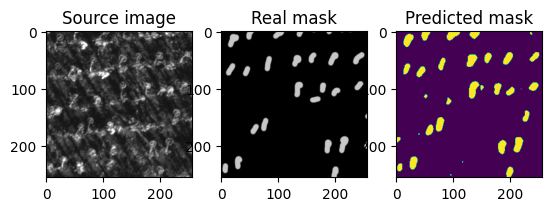

Precision: 0.18
Recall: 0.18
F1-score: 0.18
Model 39
Path: model_v0.6_0.3303_vloss0.0000_score.pth


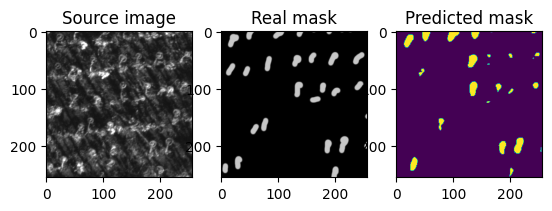

Precision: 0.53
Recall: 0.55
F1-score: 0.54
Model 40
Path: model_v0.6_0.2901_vloss0.0000_score.pth


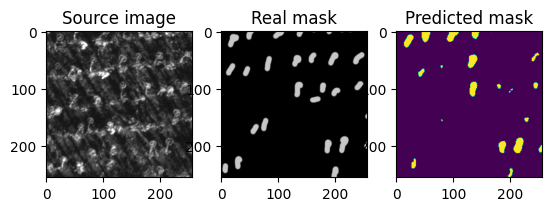

Precision: 0.5
Recall: 0.57
F1-score: 0.52
Model 41
Path: model_v0.6_0.2738_vloss0.0000_score.pth


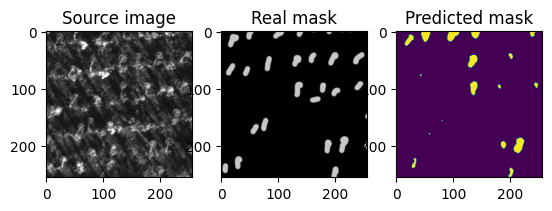

Precision: 0.27
Recall: 0.32
F1-score: 0.29
Model 42
Path: model_v0.6_0.2735_vloss0.0000_score.pth


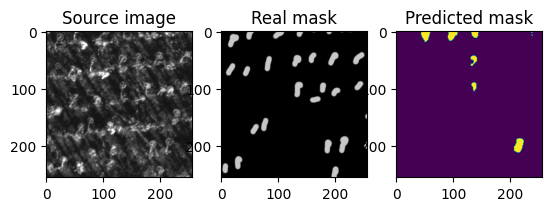

Precision: 0.21
Recall: 0.25
F1-score: 0.22


In [211]:
for i, path in enumerate(paths_to_models):
    model = activate_model(os.path.join(MODELS_DIR, path), device)
    print(f"Model {i+1}")
    print(f"Path: {path}")
    _, _, _ = visual_test_model(model, paths_all[599])

    for j, ((X, y), img_name)  in enumerate(zip(test, img_names)):
        real_mask = np.where(y.squeeze(0).numpy() > 0, 255, 0)
        pred_mask = predict(model, X.unsqueeze(0))
        pred_mask = pred_mask.squeeze(0, 1).cpu().numpy()
        pred_mask = np.where(pred_mask > 0, 255, 0)
        pred_mask = pred_mask.astype(np.uint8)
        real_mask = real_mask.astype(np.uint8)

        # plot_imgs((real_mask, pred_mask), (1, 2), ["real", "predicted"])
        kernel = np.ones((3,3),np.uint8)
        er_r = cv2.erode(real_mask,kernel,iterations = 1)
        er_p = cv2.erode(pred_mask,kernel,iterations = 1)

        # plot_imgs((er_r, er_p), (1, 2), ["real", "predicted"])
        TP, FP, FN = true_n_false_labels(er_r, er_p)

        prec = precision(TP, FP)
        rec = recall(TP, FN)
        f1sc = f1(TP, FP, FN)

        stats[f'model_{i+1}']['precision'][j] = prec
        stats[f'model_{i+1}']['recall'][j]    = rec
        stats[f'model_{i+1}']['f1-score'][j]  = f1sc
    print('Precision:',
          round(stats[f'model_{i+1}']['precision'].mean(), 2))
    print('Recall:',
          round(stats[f'model_{i+1}']['recall'].mean(), 2))
    print('F1-score:',
          round(stats[f'model_{i+1}']['f1-score'].mean(), 2))

In [212]:
stats

{'model_1': {'precision': array([0.83333333, 0.96296296, 0.75      , 1.        , 0.75      ,
         1.        , 1.        , 0.8       , 1.        , 0.89189189,
         1.        , 0.9       , 0.875     , 0.85714286, 1.        ,
         0.92592593, 0.9       , 0.44444444, 1.        , 1.        ]),
  'recall': array([0.71428571, 0.72222222, 0.42857143, 0.5       , 0.375     ,
         0.54545455, 0.625     , 0.57142857, 0.5       , 0.6875    ,
         0.80645161, 0.5       , 0.4375    , 0.5       , 0.52941176,
         0.73529412, 0.52941176, 0.30769231, 0.46666667, 0.5       ]),
  'f1-score': array([0.76923077, 0.82539683, 0.54545455, 0.66666667, 0.5       ,
         0.70588235, 0.76923077, 0.66666667, 0.66666667, 0.77647059,
         0.89285714, 0.64285714, 0.58333333, 0.63157895, 0.69230769,
         0.81967213, 0.66666667, 0.36363636, 0.63636364, 0.66666667])},
 'model_2': {'precision': array([1.        , 0.96153846, 1.        , 1.        , 0.90909091,
         1.        , 1.   

In [213]:
sorted_prec = sorted([(stats[m]['precision'].mean(), m) for m in stats.keys()], reverse=True)
sorted_rec = sorted([(stats[m]['recall'].mean(), m) for m in stats.keys()], reverse=True)
sorted_f1 = sorted([(stats[m]['f1-score'].mean(), m) for m in stats.keys()], reverse=True)

In [216]:
print(*zip(sorted_prec, sorted_rec, sorted_f1), sep='\n')

((0.9799071299071299, 'model_2'), (0.6750793650793652, 'model_12'), (0.6925561382292427, 'model_10'))
((0.9757943690296631, 'model_7'), (0.6530073867779816, 'model_11'), (0.6901864291731699, 'model_5'))
((0.9651231774761188, 'model_3'), (0.6169814213564214, 'model_10'), (0.685765214317846, 'model_12'))
((0.9301270053475935, 'model_8'), (0.5697565506389035, 'model_5'), (0.6845373256328618, 'model_4'))
((0.9299956232492999, 'model_6'), (0.5686843520779784, 'model_4'), (0.6800896576451618, 'model_3'))
((0.9154166666666669, 'model_9'), (0.5675, 'model_40'), (0.6777959271956796, 'model_7'))
((0.9136681780862814, 'model_5'), (0.55, 'model_39'), (0.6767751753077839, 'model_2'))
((0.8962659124501229, 'model_4'), (0.5490945358141753, 'model_1'), (0.6758077524002919, 'model_11'))
((0.8945350707850708, 'model_1'), (0.5377166837764664, 'model_8'), (0.6746433623140878, 'model_8'))
((0.8240638528138529, 'model_10'), (0.5349862322720379, 'model_6'), (0.6743802786846993, 'model_1'))
((0.71287823287823

In [221]:
s_prec = [stats[m]['precision'].mean() for m in stats.keys()]
s_rec = [stats[m]['recall'].mean() for m in stats.keys()]
s_f1 = [stats[m]['f1-score'].mean() for m in stats.keys()]

s = sorted(zip(s_rec, s_prec, s_f1, range(1, 43)), reverse=True)
print(*s, sep='\n')

(0.6750793650793652, 0.6980158730158731, 0.685765214317846, 12)
(0.6530073867779816, 0.7128782328782328, 0.6758077524002919, 11)
(0.6169814213564214, 0.8240638528138529, 0.6925561382292427, 10)
(0.5697565506389035, 0.9136681780862814, 0.6901864291731699, 5)
(0.5686843520779784, 0.8962659124501229, 0.6845373256328618, 4)
(0.5675, 0.505, 0.5208333333333333, 40)
(0.55, 0.5333333333333333, 0.54, 39)
(0.5490945358141753, 0.8945350707850708, 0.6743802786846993, 1)
(0.5377166837764664, 0.9301270053475935, 0.6746433623140878, 8)
(0.5349862322720379, 0.9299956232492999, 0.673138881914962, 6)
(0.5318501108338505, 0.9154166666666669, 0.6633862150810118, 9)
(0.5292992032122467, 0.9651231774761188, 0.6800896576451618, 3)
(0.526674331960229, 0.9757943690296631, 0.6777959271956796, 7)
(0.5185381136950904, 0.9799071299071299, 0.6767751753077839, 2)
(0.48309523809523813, 0.48309523809523813, 0.48309523809523813, 18)
(0.46419384057971, 0.43919384057971006, 0.4491938405797101, 13)
(0.4595588235294118, 0.